In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import LinearNDInterpolator
import os

In [3]:
from pycaz.schism import read_gr3, read_hgrid

# hgrid.g3

- Load the mesh
- Interpolate the bathymetry from global dataset
- Save as hgrid.gr3 file

In [4]:
fname = 'Inland_from_break_1000_10000.grd'
hgrid = read_hgrid(fname)

In [5]:
hgrid.x.min(), hgrid.x.max()

(43.0833222966, 50.6389427981)

In [6]:
import xarray as xr
ds = xr.open_dataset('../../../../../../Data/GEBCO2022/Global/GEBCO_2022_sub_ice_topo.nc', chunks={'lon':1000, 'lat':1000})
ds

<xarray.Dataset>
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    crs        |S1 ...
    elevation  (lat, lon) int16 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    references:                      DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    node_offset:                     1.0

In [7]:
lon_select = ds.lon[np.logical_and(ds.lon >= 40, ds.lon <=53)]
lat_select = ds.lat[np.logical_and(ds.lat >= -27, ds.lat <= -11)]
ds_select = ds.sel(lon=lon_select, lat=lat_select)

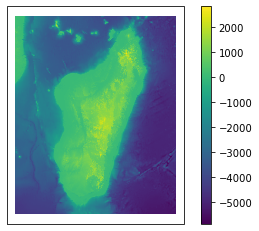

In [8]:
# Plotting the selected data from where the interpolation will be done
X, Y = np.meshgrid(ds_select.lon, ds_select.lat)
Z = ds_select.elevation
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
pc = ax.pcolormesh(X, Y, Z)
plt.colorbar(pc)

In [9]:
# Creating the inpolating function
# griddata function can also be used which does the create the interpolator
# xy = np.vstack((X.flatten(), Y.flatten())).T
# f = LinearNDInterpolator(points=xy, values=Z.values.flatten())

In [10]:
# LinearNDInterpolator takes 3min, can it be done better using grid data?
# No, griddata takes more time and RAM to do it
# What would be the better solution?
# from scipy.interpolate import griddata
# griddata(xy, Z.values.flatten(), hgrid.xy)

In [11]:
# For regular grid scipy.interpolate has a RegularGridInterpolator
# The original data is (lat, lon) format, so we need to give the points in (lat, lon) tuple
# Takes less than 0.5s!
from scipy.interpolate import RegularGridInterpolator
f = RegularGridInterpolator(points=(ds_select.lat, ds_select.lon), values=ds_select.elevation.values)
f(hgrid.xy[:, [1, 0]])

array([-597.68747182, -558.29434964, -554.46512032, ..., -344.63404496,
       -346.09431762, -483.45935177])

In [12]:
# Setting the depth value
# Multiplied by -1 to make depth positive
hgrid.data = np.atleast_2d(f(hgrid.xy[:, [1, 0]]) * -1).T

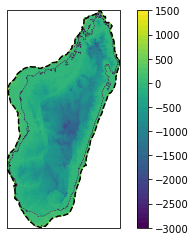

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
tc = ax.tricontourf(
    hgrid.x, 
    hgrid.y, 
    hgrid.elems[:, 0:3]-1, 
    hgrid.data[:, 0], 
    levels=np.arange(-3000, 1501, 100))
ax.tricontour(
    hgrid.x, 
    hgrid.y, 
    hgrid.elems[:, 0:3]-1, 
    hgrid.data[:, 0], 
    levels=[0],
    linewidths=0.5, 
    linestyles='--')
# ax.triplot(
#     hgrid.x, 
#     hgrid.y, 
#     hgrid.elems[:, 0:3]-1,
#     linewidth=0.1,
#     linestyle='--')
ax.plot(
    hgrid.open_bnds[1]['xy'][:, 0], 
    hgrid.open_bnds[1]['xy'][:, 1], 
    linestyle='--', 
    color='black')
plt.colorbar(tc)
plt.savefig('hgrid.png', dpi=150, bbox_inches='tight')

In [14]:
hgrid.header = 'Madagascar 1km'
hgrid.write('hgrid.gr3', overwrite=True)

# bctides.in

In [15]:
bctides = hgrid.get_bctides()

In [16]:
from pycaz.schism.bc import consts

from pycaz.tide.utide import utide_names
from pycaz.tide.utide import utide_freqs
from pycaz.tide.utide import nodal_factor

start_date = pd.to_datetime('2018-01-01 00:00:00')
rnday = 365 # days
lat = -25

available_consts, missing_consts = utide_names(consts)
available_freqs, missing_freqs = utide_freqs(consts)

t = [start_date, start_date + pd.to_timedelta(rnday, unit='d')]
dict_nf = nodal_factor(t=t, consts=available_consts, lat=lat, correct_phase=False)

dict_tidefr = {}

for const in available_freqs:
    dict_tidefr[const] = {
        'amig': available_freqs[const]*2*np.pi/3600, # angular freq (rad/sec)
        'ff':dict_nf[const]['nf'], # nodal factor (unitless)
        'face':dict_nf[const]['ear'] # earth equilibrium argument (degrees)
        }

In [17]:
bctides.add_tidefr(dict_tidefr)

In [18]:
from pycaz.tide.atlas import read_atlas
fes2014_dir = '../../../../../../../Developments/Tide_Atlas/data/FES2014/fes2014b_elevation/'
fes2014 = read_atlas(atlas_dir=fes2014_dir, lon180=False)

units are set to {'amp': 'cm', 'pha': 'degrees'}


In [19]:
from scipy.interpolate import RegularGridInterpolator
ds = fes2014['M2'].amp
dims = ds.dims
f = RegularGridInterpolator(points=(ds[dims[0]], ds[dims[1]]), values=ds.values, method='linear')
xy = pd.DataFrame(bctides.open_bnds[1].xy, columns=['lon', 'lat']).loc[:, dims].values
f(xy)

array([72.95037277, 72.95754107, 72.96012255, ..., 73.67323875,
       73.35220345, 73.1180608 ])

In [20]:
# Something is wrong with complex computation
# fes2014_bnd_cp = fes2014.interp(xy=bctides.open_bnds[1].xy, method='complex')
# np.sum(np.isnan(fes2014_bnd_cp['M2'].amp.values))

In [21]:
fes2014_bnd_ln = fes2014.interp(xy=bctides.open_bnds[1].xy, method='linear')
np.sum(np.isnan(fes2014_bnd_ln['M2'].amp.values))

units are set to {'amp': 'cm', 'pha': 'degrees'}


34

In [22]:
fes2014_bnd_nn = fes2014.interp(xy=bctides.open_bnds[1].xy, method='nearest')
np.sum(np.isnan(fes2014_bnd_nn['M2'].amp.values))

units are set to {'amp': 'cm', 'pha': 'degrees'}


0

In [23]:
bnd_dict = {
    const:np.vstack(
        (
            fes2014_bnd_nn[const].amp/100, # cm to meter 
            (fes2014_bnd_nn[const].pha)*(fes2014_bnd_nn[const].pha >=0 ) + (360 + fes2014_bnd_nn[const].pha)*(fes2014_bnd_nn[const].pha < 0 )
        )).T for const in bctides.tidefr['const']
}
bctides.open_bnds[1]['iettype'] = 3
bctides.open_bnds[1]['et'][3] = bnd_dict

In [24]:
bctides.write(fname='bctides.in', replace=True)

# vgrid.in

# manning.gr3

In [25]:
manning = hgrid.gr3
manning.data = manning.data * 0 + 0.025
manning.write('manning.gr3', overwrite=True)

# sflux/

In [26]:
def specific_humidity(T_dew, p):
    """
    https://github.com/Unidata/MetPy/issues/791
    """
    e0 = 6.113 #hPa
    p_hpa = p / 100 #Pa->hPa
    c_water = 5423
    T0 = 273.15 #K

    q = (622*e0/p)*np.exp(c_water*(T_dew - T0)/(T_dew * T0)) # g/kg
    
    q = q/1000 # kg/kg
    return(q)

In [62]:
from tqdm import tqdm
from pycaz.schism.sflux import Sflux
from pycaz.core.grid import Grid
import dask

era5_dir = '/run/media/khan/BandSOS/Cyclone_Rainfall/ERA5/'
ds = xr.open_dataset(os.path.join(era5_dir, 'era_swio_2018.nc'))
sflux_extent = hgrid.extent() + [-0.5, 0.5, -0.5, 0.5]

lon_select = ds.longitude[np.logical_and(ds.longitude >= sflux_extent[0], ds.longitude <= sflux_extent[1])].values
lat_select = ds.latitude[np.logical_and(ds.latitude >= sflux_extent[2], ds.latitude <= sflux_extent[3])].values[::-1] # increasing bottom to top
time_select = ds.time[np.logical_and(ds.time >= pd.to_datetime('2018-01-01 00:00:00'), ds.time <= pd.to_datetime('2019-01-01 00:00:00'))]
sflux_grid = Grid(x=lon_select, y=lat_select)
sflux_air = Sflux(grid=sflux_grid, basedate=pd.to_datetime(ds.time.values[0]), sflux_type='air', nstep=24*30, path='./sflux')
sflux_prc = Sflux(grid=sflux_grid, basedate=pd.to_datetime(ds.time.values[0]), sflux_type='prc', nstep=24*30, path='./sflux')
sflux_rad = Sflux(grid=sflux_grid, basedate=pd.to_datetime(ds.time.values[0]), sflux_type='rad', nstep=24*30, path='./sflux')

dt = pd.Timedelta(time_select.diff(dim='time').values[0])
print(dt)

for timestep in tqdm(time_select.values):
    # sflux_air
    uwind = ds.u10.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    vwind = ds.v10.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    prmsl = ds.msl.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    stmp = ds.t2m.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    stfh = specific_humidity(
        T_dew=ds.d2m.sel(longitude=lon_select, latitude=lat_select, time=timestep),
        p=prmsl
    )

    flux_air = {
        'uwind':uwind,
        'vwind':vwind,
        'prmsl':prmsl,
        'stmp':stmp,
        'spfh':stfh
    }
    
    sflux_air.write(at=pd.to_datetime(timestep), flux=flux_air)

    # sflux_prc
    prate = ds.mtpr.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    flux_prc = {
        'prate':prate
    }

    sflux_prc.write(at=pd.to_datetime(timestep), flux=flux_prc)

    # sflux_rad
    dlwrf = ds.msdwlwrf.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    dswrf = ds.msdwswrf.sel(longitude=lon_select, latitude=lat_select, time=timestep)
    flux_rad = {
        'dlwrf':dlwrf,
        'dswrf':dswrf
    }

    sflux_rad.write(at=pd.to_datetime(timestep), flux=flux_rad)

sflux_air.write(at=pd.to_datetime(timestep) + dt, flux=flux_air)
sflux_prc.write(at=pd.to_datetime(timestep) + dt, flux=flux_prc)
sflux_rad.write(at=pd.to_datetime(timestep) + dt, flux=flux_rad)

sflux_air.write(at=pd.to_datetime(timestep) + dt + dt, flux=flux_air)
sflux_prc.write(at=pd.to_datetime(timestep) + dt + dt, flux=flux_prc)
sflux_rad.write(at=pd.to_datetime(timestep) + dt + dt, flux=flux_rad)

sflux_air.finish()
sflux_prc.finish()
sflux_rad.finish()

sflux_air.sfluxtxt(dt=dt)
sflux_prc.sfluxtxt(dt=dt) # does not actually change anything
sflux_rad.sfluxtxt(dt=dt) # does not actually change anything

0 days 01:00:00


100%|██████████| 8760/8760 [02:18<00:00, 63.31it/s]


# windrot_geo2proj

In [ ]:
windrot_geo2proj = hgrid.gr3
windrot_geo2proj.data = windrot_geo2proj.data * 0
windrot_geo2proj.write('windrot_geo2proj.gr3', overwrite=True)

# elev.ic

Creating the elev.ic was difficult due to the way the gr3 data is currently handled. I am thinking that it is probably not a good idea to hold hgrid or gr3 data the way I am currently holding. It is probably more useful to create a data object with multiple accessor.

In [51]:
# threshold
elev_ic = hgrid.gr3.copy()
elev_ic.data = (elev_ic.data * 0)*(elev_ic.data >= 0) + (elev_ic.data * -1 - 0.01)*(elev_ic.data < 0)
elev_ic.write('elev.ic', overwrite=True)

# station.in